In [11]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import open_clip
import torch
from einops import rearrange
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from PIL import Image
from torch import nn
from tqdm import tqdm

from modules import CME


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.set_default_dtype(torch.float64)
%config InlineBackend.figure_format='retina'

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r"\usepackage{amsmath}")
plt.rc('text.latex', preamble=r"\usepackage{amsmath} \everymath{\bf}")

SAVEFILE_SUFFIX = "clip"
CLIP_MODEL = "ViT-B-32"
CLIP_PRETRAINED = "laion2b_s34b_b79k"

In [12]:
clip_model, _, preprocess = open_clip.create_model_and_transforms(CLIP_MODEL, pretrained=CLIP_PRETRAINED, device=device)
clip_model.eval()
tokenizer = open_clip.get_tokenizer(CLIP_MODEL)

In [13]:
class EM(nn.Module):
    def __init__(self, WM_n_taus, n_features, M_model):
        super(EM, self).__init__()

        self.WM_n_taus = WM_n_taus
        self.n_features = n_features
        self.M_model = M_model

    def forward(self, fs, til_fs, M, M_F, A):
        #     fs.shape: (seq_len, n_features)
        # til_fs.shape: (seq_len, n_features, n_taus)
        #      A.shape: (n_taus, n_features, n_features)   # attention window
        #      M.shape: (n_taus, n_features, n_features)
        #    M_F.shape: (n_taus * n_features * n_features, M_n_s)
        #
        #        Ms.shape: (seq_len, n_taus, n_features, n_features)
        #     til_M.shape: (M_n_taus, n_taus, n_features, n_features)
        
        assert A.dim() == 3

        if M is None:
            M = fs.new_zeros((self.WM_n_taus, self.n_features, self.n_features))
        
        # update M
        for (f, til_f) in zip(fs, til_fs):  # iterate over sequence dim
            dM = torch.einsum("tba, b, at -> tba", (A, f, til_f))
            M = M + dM
        
            # flatten non-sequence dimensions
            M_flat = rearrange(
                dM, 
                'WM_n_tau n_feat_post n_feat_pre -> 1 1 (WM_n_tau n_feat_post n_feat_pre)', 
                WM_n_tau=self.WM_n_taus, 
                n_feat_post=self.n_features, 
                n_feat_pre=self.n_features
            )

            # update log-spaced history of M
            til_Ms, M_F = self.M_model(M_flat, M_F, alphas=None)

            # unflatten
            til_M = til_Ms[:, 0]  # remove seq dim
            til_M = rearrange(
                til_M, 
                '1 (WM_n_tau n_feat_post n_feat_pre) M_n_tau -> M_n_tau WM_n_tau n_feat_post n_feat_pre', 
                WM_n_tau=self.WM_n_taus,
                n_feat_post=self.n_features,
                n_feat_pre=self.n_features,
                M_n_tau=self.M_model.n_taus
            )
        
            self.til_M = til_M
            # self.Ms = Ms

        return M, M_F

    def get_P(self, M, f):
        # M.shape: (seq_len, n_taus, n_features, n_features)
        # f.shape: (seq_len, n_features)
        # returns: (seq_len, n_taus, n_features)
        assert M.dim() == 4
        return torch.einsum("ztba, za -> ztb", (M, f))

    def get_til_f_bar(self, M, f):
        # M.shape: (seq_len, n_taus, n_features, n_features)
        # f.shape: (seq_len, n_features)
        # returns: (seq_len, n_taus, n_features)
        assert M.dim() == 4
        return torch.einsum("ztba, zb -> zta", (M, f))

    def get_P_til_f(self, M, til_f):
        #     M.shape: (seq_len, n_taus, n_features, n_features)
        # til_f.shape: (seq_len, n_features, n_taus)
        #     returns: (seq_len, n_taus, n_features)
        assert M.dim() == 4
        return torch.einsum("ztba, zat -> ztb", (M, til_f))

    def get_P_delta(self, M, delta_til_f):
        #     M.shape: (n_taus_pre, n_features_post, n_features_pre)
        # til_f.shape: (delta, n_features_pre, n_taus_pre)
        #     returns: (delta, n_taus_pre, n_features_post)
        assert M.dim() == 3
        M = M.unsqueeze(0).expand(delta_til_f.size()[0],-1,-1,-1)
        return torch.einsum("ztba, zat -> ztb", (M, delta_til_f))
    
    def get_P_delta_sum(self, M, delta_til_f):
        #           M.shape: (n_taus, n_features_post, n_features_pre)
        # delta_til_f.shape: (delta, n_features_pre, n_taus_pre)
        #           returns: (n_features_post, delta)
        assert M.dim() == 3
        M = M.unsqueeze(0).expand(delta_til_f.size()[0],-1,-1,-1)
        return torch.einsum("dtba, dat -> bd", (M, delta_til_f))

    def extra_repr(self):
        return f"n_taus={self.n_taus}, n_features={self.n_features}, M_model={self.M_model}"

In [29]:
import matplotlib.transforms as transforms
from matplotlib.offsetbox import TextArea

# https://stackoverflow.com/questions/42827978/image-perspective-transform-using-pillow
def find_coefs(original_coords, warped_coords):
    matrix = []
    for p1, p2 in zip(original_coords, warped_coords):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = np.matrix(matrix, dtype=np.float32)
    B = np.array(warped_coords).reshape(8)

    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)


def plot_figure(
        t, 
        inputs, 
        til_f, 
        P_delta_sum_dict: dict[str, tuple[str, torch.Tensor, int]], 
        x_tstr, 
        labels, 
        selected_frames: list[tuple[int, Image.Image]], 
        timeline_regions: list[tuple[str, int, int, list[int]]], 
        reference_embeddings: list[tuple[str, torch.Tensor]],
        dt,
        save_path
    ):
    Nt = inputs.shape[0]
    x = np.linspace(0, Nt, Nt, endpoint=False)
    x_tstr = x_tstr.cpu().numpy()

    n_embed_vis = 8
    
    # get top most different features between first two reference embeddings
    dist = torch.abs(reference_embeddings[0][1][0] - reference_embeddings[1][1][0])
    embed_vis = torch.argsort(dist, descending=True)[:n_embed_vis].cpu().numpy()


    x_min = -83  # secs
    x_max = 13

    vmin = inputs[..., embed_vis].min()
    vmax = inputs[..., embed_vis].max()   

    text = tokenizer(labels).to(device)
    with torch.no_grad(), torch.autocast("cuda"):
        text_embeddings = clip_model.encode_text(text, normalize=True)

    til_f = til_f.T  # (n_features, n_taus) -> (n_taus, n_features)
    
    # normalize feature (embedding) dim
    til_f_normed = til_f / torch.linalg.norm(til_f, dim=-1, keepdim=True)
    
    input_probs = (100.0 * inputs @ text_embeddings.T).softmax(dim=-1).cpu().numpy()
    til_f_probs = (100.0 * til_f_normed @ text_embeddings.double().T).softmax(dim=-1).cpu().numpy()
        
    P_delta_sum_normed = {}
    P_delta_sum_probs = {}
    for k, (_, P_delta_sum, _) in P_delta_sum_dict.items():
        P_delta_sum = P_delta_sum.T  # (n_features, delta) -> (delta, n_features)
        P_delta_sum_normed[k] = P_delta_sum / torch.linalg.norm(P_delta_sum, dim=-1, keepdim=True)
        P_delta_sum_probs[k] = (100.0 * P_delta_sum_normed[k] @ text_embeddings.double().T).softmax(dim=-1).cpu().numpy()
    
    n_labels = len(labels)

    fig = plt.figure(
        figsize=(7, 6),  # w, h
        dpi=200,
        layout="constrained",
        facecolor='w', 
        edgecolor='k', 
    )
    top, bottom = fig.subfigures(
        nrows=2, ncols=1, height_ratios=[1, 1]
    )

    left, right = bottom.subfigures(
        nrows=1, ncols=2, width_ratios=[1.5, 1]
    )

    mosaic_top = [
        ["timeline"], 
        ["inputs"]
    ]
    axd_top = top.subplot_mosaic(
        mosaic_top,
        height_ratios=[1, 4],
        sharex=True
    )

    mosaic_right = []
    keys = list(P_delta_sum_dict.keys())
    for k in keys:
        mosaic_right.append(["cb", f"memory_{k}", f"pred_{k}"])
        mosaic_right.append(["cb", f"memory_{k}", f"pred_{k}"])
    

    mosaic_right[0][0] = "."
    mosaic_right[-1][0] = "."
    
    axd_right = right.subplot_mosaic(
        mosaic_right,
        width_ratios=[0.1, 1, 1.1],
        sharex=False,
    )

    mosaic_left = [
        [".", ".", "."]] + [[".", f"probs_{k2}", "."] for k2 in keys] + [[".", ".", "."]
       ]
    axd_left = left.subplot_mosaic(
        mosaic_left,
        width_ratios=[0.2, 1, 0.2],
        height_ratios=[0.4] + [1] * len(keys) + [0.55],
    )

    axd = {**axd_top, **axd_left, **axd_right}
    
    top.get_layout_engine().set(h_pad=0.01)
    right.get_layout_engine().set(h_pad=0.01)

    # Timeline
    ax = axd["timeline"]

    # shaded regions
    for label, start, end, marks in timeline_regions:
        ax.axvspan((start-t)*dt, (end-t)*dt, alpha=0.2, color='red')
        ax.text(
            (((start + end) / 2) - t) * dt, 0.5, label, 
            ha="center", va="center", fontsize=10, color='k'
        )
        for mark in marks:
            ax.axvline((mark-t)*dt, color="k", linestyle='-', lw=0.5)

    ax.tick_params(axis='x', which='both', bottom=False)
    ax.set_yticks([])

    # selected video frames
    for ix, frame in selected_frames:
        w = frame.width
        h = frame.height

        # perspective warp
        coeffs = find_coefs(
            [(w*0.4, 0), (w*0.4, h), (w*0.6, h*0.8), (w*0.6, h*0.2)],
            [(0, 0), (0, h), (w, h), (w, 0)], 
        )

        frame = frame.convert("RGBA").transform(
            frame.size, Image.PERSPECTIVE, coeffs, Image.BILINEAR
        )

        im = OffsetImage(frame, zoom=70 / frame.height)
        im.image.axes = ax

        ab = AnnotationBbox(im, 
            ((ix - t) * dt, 1),
            xybox=(0., 50.),
            xycoords='data',
            boxcoords="offset points",
            pad=0.0,
            arrowprops=dict(arrowstyle="-", mutation_scale=3),
            frameon=False,
        )
        
        ax.add_artist(ab)


    # Input embeddings
    ax = axd["inputs"]
    ax.pcolormesh(
        (x[:t+1]-t)*dt, 
        np.arange(n_embed_vis), 
        inputs.T.cpu()[embed_vis],
        shading='nearest', cmap='viridis',
        vmin=vmin, vmax=vmax,
    )
    # ax.axvline(x=0, lw=2, color='k')

    ax.set_xlim(x_min, x_max)
    ax.set_xticks([-80, -40, -20, -12, 0, 12])
    ax.set_xlabel(r"$t$", fontsize=20)

    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_yticks([])
    ax.set_ylabel(r"$f$", fontsize=20, rotation=0, labelpad=5, va="center", ha="right")

    for k, (text, _, rewind_steps) in P_delta_sum_dict.items():
        ax.axvline(-rewind_steps*dt, color="k", linestyle='--')
        
        offsetbox = TextArea(text)
        ab = AnnotationBbox(offsetbox, 
            (-rewind_steps*dt, -0.5),
            xybox=(10., -30.),
            xycoords='data',
            boxcoords="offset points",
            box_alignment=(0., 0.),
            arrowprops=dict(arrowstyle="->", mutation_scale=2),
            # frameon=False,
        )
        ax.add_artist(ab)

    for k, (text, _, _) in P_delta_sum_dict.items():
        is_first = k == list(keys)[0]
        is_last = k == list(keys)[-1]


        # Memory embeddings
        ax = axd[f"memory_{k}"]
        ax.pcolormesh(
            -x_tstr * dt, 
            np.arange(n_embed_vis), 
            til_f.T.cpu()[embed_vis], 
            shading='nearest', cmap='viridis', 
            vmin=vmin, vmax=vmax, 
        )

        # manually draw border lines at each halfway point
        x_midpoints = -(x_tstr[:-1] + np.diff(x_tstr) / 2) * dt
        for x in x_midpoints:
            ax.axvline(x, color='k', lw=0.2)

        ax.set_xticks(-x_tstr * dt, minor=True)
        ax.set_yticks([])

        # labels
        if is_last:
            xticks = [-12]
            ticklabels =  [f"${i}$" for i in xticks]
            ax.set_xticks(xticks, ticklabels, fontsize=12)
        else:
            ax.set_xticks([])

        if is_first:
            ax.set_title(r"$\tilde{f}$", fontsize=20)

        # Prediction embeddings
        ax = axd[f"pred_{k}"]
        pcm = ax.pcolormesh(
            x_tstr * dt, 
            np.arange(n_embed_vis), 
            P_delta_sum_normed[k].T.cpu()[embed_vis], 
            shading='nearest', cmap='viridis', 
            vmin=vmin, vmax=vmax, 
        )

        # manually draw border lines at each halfway point
        x_midpoints = (x_tstr[:-1] + np.diff(x_tstr) / 2) * dt
        for x in x_midpoints:
            ax.axvline(x, color='k', lw=0.2)
        ax.set_xticks(x_tstr * dt, minor=True)

        ax.set_yticks([])

        if is_last:
            xticks = [12]
            ticklabels =  [f"${i}$" for i in xticks]
            ax.set_xticks(xticks, ticklabels, fontsize=12)
            # invisible xlabel to make space
            ax.set_xlabel(r"$\overset{\ast}{\tau}$", fontsize=20, color='w')
        else:
            ax.set_xticks([])

        if is_first:
            ax.set_title(r"$\tilde{p}_\delta$", fontsize=20)

        # Colorbar
        fig.colorbar(pcm, cax=axd["cb"], orientation="vertical", location="left")


        # Prediction probabilities
        ax = axd[f"probs_{k}"]
        # horizontal bar plot
        ax.bar(
            labels,  
            P_delta_sum_probs[k].mean(axis=0),
            # height=0.1,
            zorder=10,
        )
        ax.set_ylabel(text, fontsize=14, rotation=0, labelpad=5, va="center", ha="right")

        ax.set_ylim(0, 1)

        # remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ticklabels = [r"$0$", r"$1$"]
        ax.set_yticks([0, 1], ticklabels, fontsize=14)
        ax.tick_params(axis="y", direction="in")

        if not is_last:
            ax.set_xticklabels([])
        
    # manually place taustar label and 0
    fig.text(0.87, 0.0665, r"$0$", ha="center", va="center", fontsize=12)
    fig.text(0.87, 0.013, r"$\overset{\ast}{\tau}$", ha="center", va="center", fontsize=20)

    # execute layout to get proper data positions
    fig.get_layout_engine().execute(fig)
    
    # data coords -> display coords -> right subfigure coords
    trans = axd["inputs"].transData + right.transSubfigure.inverted()

    for k in keys:
        # get position of limits in figure coordinates
        ax = axd[f"pred_{k}"]

        xmin, xmax = ax.get_xlim()
        fig_xmin, fig_xmax = trans.transform([(xmin, 0), (xmax, 0)])
        fig_xmin, fig_xmax = fig_xmin[0], fig_xmax[0]

        ax.set_position([fig_xmin, ax.get_position().y0, fig_xmax-fig_xmin, ax.get_position().height])

    for k in keys:
        # get position of limits in figure coordinates
        ax = axd[f"memory_{k}"]
        
        xmin, xmax = ax.get_xlim()
        fig_xmin, fig_xmax = trans.transform([(xmin, 0), (xmax, 0)])
        fig_xmin, fig_xmax = fig_xmin[0], fig_xmax[0]
        
        ax.set_position([fig_xmin, ax.get_position().y0, fig_xmax-fig_xmin, ax.get_position().height])

    path = Path(save_path)
    path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(path, dpi=300, bbox_inches='tight', pad_inches = 0.0)

In [15]:
def load_video_embeddings(video_path, frame_skip: int) -> tuple[torch.Tensor, list[Image.Image], float]:
    """
    Returns a list of frames from 'video_path', skipping 'frame_skip' frames each time.
    """
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    dt = frame_skip / fps

    frames = []
    images = []
    frame_count = 0

    with tqdm(total=total_frames // frame_skip, desc="Processing frames") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_count % frame_skip == 0:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 

                frame = Image.fromarray(frame_rgb)
                frames.append(frame)

                image = preprocess(frame)
                images.append(image)
                
                pbar.update(1)

            frame_count += 1
    cap.release()    
    
    ("Computing embeddings...")
    images = torch.stack(images).to(device)  # stack time over dim 0
    with torch.no_grad(), torch.autocast("cuda"):
        embeddings = clip_model.encode_image(images, normalize=True)

    return embeddings, frames, dt

In [ ]:
embeddings_hotel, frames_hotel, dt = load_video_embeddings("media/hotel-trimmed.mp4", frame_skip=2)
embeddings_eiffel, frames_eiffel, _ = load_video_embeddings("media/eiffel-trimmed.mp4", frame_skip=5)
embeddings_bigben, frames_bigben, _ = load_video_embeddings("media/bigben-trimmed.mp4", frame_skip=5)
# just use dt based hotel video framerate

Processing frames:  85%|████████▍ | 50/59 [00:00<00:00, 50.09it/s]


In [ ]:
# random embeddings
embeddings_rand = torch.randn((400, 512), device=device)
embeddings_rand = embeddings_rand / torch.linalg.norm(embeddings_rand, dim=-1, keepdim=True)

# frames of random sample images
frames_rand = []
for i in range(embeddings_rand.shape[0] // 2):
    im = Image.open("media/Old_growth_forest_scenic.jpg")
    frames_rand.append(im)

for i in range(embeddings_rand.shape[0] // 2):
    im = Image.open("media/Erie_Railroad_motor_car_4002_in_Salamanca_1911_postcard.webp.png")
    frames_rand.append(im)

rand_len = 200
embeddings_rand1 = embeddings_rand[:rand_len]
embeddings_rand2 = embeddings_rand[rand_len:rand_len*2]

frames_rand1 = frames_rand[:rand_len]
frames_rand2 = frames_rand[rand_len:rand_len*2]

embeddings = torch.cat(
    [
        embeddings_hotel, 
        embeddings_eiffel, 
        embeddings_rand1,
        embeddings_hotel, 
        embeddings_bigben, 
        embeddings_rand2,
        embeddings_hotel
    ], 
    dim=0
)

inputs = embeddings[None, :, :]  # add batch dim
_, Nt, n_features = inputs.shape

print(embeddings.shape)
print(inputs.shape, inputs.dtype)

frames_ep1 = frames_hotel + frames_eiffel
frames_ep2 = frames_hotel + frames_bigben

frames = frames_ep1 + frames_rand1 + frames_ep2 + frames_rand2 + frames_hotel

ep1_start = 0
ep1_end = ep1_start + len(frames_ep1) - 1

ep2_start = ep1_end + len(frames_rand1) + 1
ep2_end = ep2_start + len(frames_ep2) - 1

ep3_start = ep2_end + len(frames_rand2) + 1
ep3_end = ep3_start + len(frames_hotel)

reference_embeddings = [
    ("eiffel", embeddings_eiffel.mean(dim=0, keepdim=True)), 
    ("bigben", embeddings_bigben.mean(dim=0, keepdim=True)), 
]

timeline_regions = [
    # label, start, end, interior markers
    ("Paris Trip", ep1_start, ep1_end, [ep1_start + len(frames_hotel),]),
    ("London Trip", ep2_start, ep2_end, [ep2_start + len(frames_hotel),]),
    ("Semantic Cue", ep3_start, ep3_end, [])
]

frames_ixs = [
    # ep1
    ep1_start + 50,
    ep1_start + 130, 
    ep1_start + 180,
    # rand
    ep1_end + 70, 
    # ep2
    ep2_start + 50,
    ep2_start + 130, 
    ep2_start + 180, 
    # rand
    ep2_end + 70,
    # ep3
    ep3_start + 50,
    ep3_start + 130,
    # ep3_start + 350,
]

selected_frames = [ (ix, frames[ix]) for ix in frames_ixs ]

torch.Size([990, 512])
torch.Size([1, 990, 512]) torch.float32


In [18]:
# Working Memory
WM_model = CME(
    tau_min=1 / dt, # Peak time of the first node in the reconstruction
    tau_max=12 / dt,   # Peak time of the last node in the reconstruction
    n_taus=16,        # Number of nodes in the reconstruction (the inverse Laplace transform (tilde{f}) of the input)
    max_fn_evals=11,  # Order of the derivative in inverse Laplace transform, larger k causes more narrow peaks in tilde{f}
    g=0,              # Amplitude scaling of nodes in tilde{f}: g=1->equal amplitude, g=0->power-law decay of amplitude)
    batch_first=True,
).to(device)
F = None

# Episodic Memory
M_model = CME(
    tau_min=5 / dt,     # Peak time of the first node in the reconstruction
    tau_max=80 / dt,    # Peak time of the last node in the reconstruction
    n_taus=20,          # Number of nodes in the reconstruction (the inverse Laplace transform (tilde{M}) of the input))
    max_fn_evals=9,     # Order of the derivative in inverse Laplace transform, larger k causes more narrow peaks in tilde{M}
    g=1,                # Amplitude scaling of nodes in tilde{M}: g=1->equal amplitude, g=0->power-law decay of amplitude)
    batch_first=True,
).to(device)
M_F = None

EM_model = EM(WM_n_taus=WM_model.n_taus, n_features=n_features, M_model=M_model).to(device)
M = None

lambdas = torch.ones(WM_model.n_taus, n_features, n_features, device=device)  # (taus, past, future)

In [19]:
print(f"{len(frames_ep1) = }")
print(f"{len(frames_ep2) = }")

print("WM_model", WM_model.tau_min, WM_model.tau_max, WM_model.n_taus)
print("M_model", M_model.tau_min, M_model.tau_max, M_model.n_taus)

len(frames_ep1) = 210
len(frames_ep2) = 215
WM_model 11.934504883804337 143.21405860565204 16
M_model 59.67252441902168 954.7603907043468 20


In [20]:
# Run model

t2 = inputs.shape[1] - 1

# reset hidden states
F = None
M = None
M_F = None

with torch.no_grad():
    steps = 1
    for f in inputs[:, :t2, :].split(steps, dim=1):
        til_f, F = WM_model(f, F, alphas=None)
        M, M_F = EM_model(f[0], til_f[0], M, M_F, A=lambdas)

til_f = til_f[:, -1]  # take last time step


In [21]:
print(f.shape)
print(til_f.shape, F.shape)
print(til_f.min(), til_f.max())
print(M.shape, M_F.shape)

torch.Size([1, 1, 512])
torch.Size([1, 512, 16]) torch.Size([1, 512, 16, 11])
tensor(-0.4155, device='cuda:0', dtype=torch.float64) tensor(0.4136, device='cuda:0', dtype=torch.float64)
torch.Size([16, 512, 512]) torch.Size([1, 4194304, 20, 9])


In [22]:
# M
delta_til_f = WM_model.get_translations(F)
delta_til_f = delta_til_f[0]  # 0th batch

P_delta = EM_model.get_P_delta(M, delta_til_f)
P_delta_sum_M = torch.einsum("dtf -> fd", P_delta)
# P_delta_sum = None

x_tstr = WM_model.tau_stars
labels = ["Paris", "London"]

In [23]:
# til_M, pointer at first set of inputs

rewind_target = 410   # steps
rewind_idx = (EM_model.M_model.tau_stars - rewind_target).abs().argmin()

til_M_t = EM_model.til_M[rewind_idx]
rewind_steps_london = M_model.tau_stars[rewind_idx].to("cpu").item()

print(f"Reconstructing memory from {rewind_steps_london:.2f} steps ago.")
print(f"Simulated M is at timestep {t2 - rewind_steps_london:.2f}")

P_delta = EM_model.get_P_delta(til_M_t, delta_til_f)
P_delta_sum_london = torch.einsum("dtf -> fd", P_delta)

Reconstructing memory from 397.78 steps ago.
Simulated M is at timestep 591.22


In [24]:
# til_M, pointer at first set of inputs

rewind_target = 830  # steps
rewind_idx = (EM_model.M_model.tau_stars - rewind_target).abs().argmin()

til_M_t = EM_model.til_M[rewind_idx]
rewind_steps_paris = M_model.tau_stars[rewind_idx].to("cpu").item()

print(f"Reconstructing memory from {rewind_steps_paris:.2f} steps ago.")
print(f"Simulated M is at timestep {t2 - rewind_steps_paris:.2f}")

P_delta = EM_model.get_P_delta(til_M_t, delta_til_f)
P_delta_sum_paris = torch.einsum("dtf -> fd", P_delta)

Reconstructing memory from 825.12 steps ago.
Simulated M is at timestep 163.88


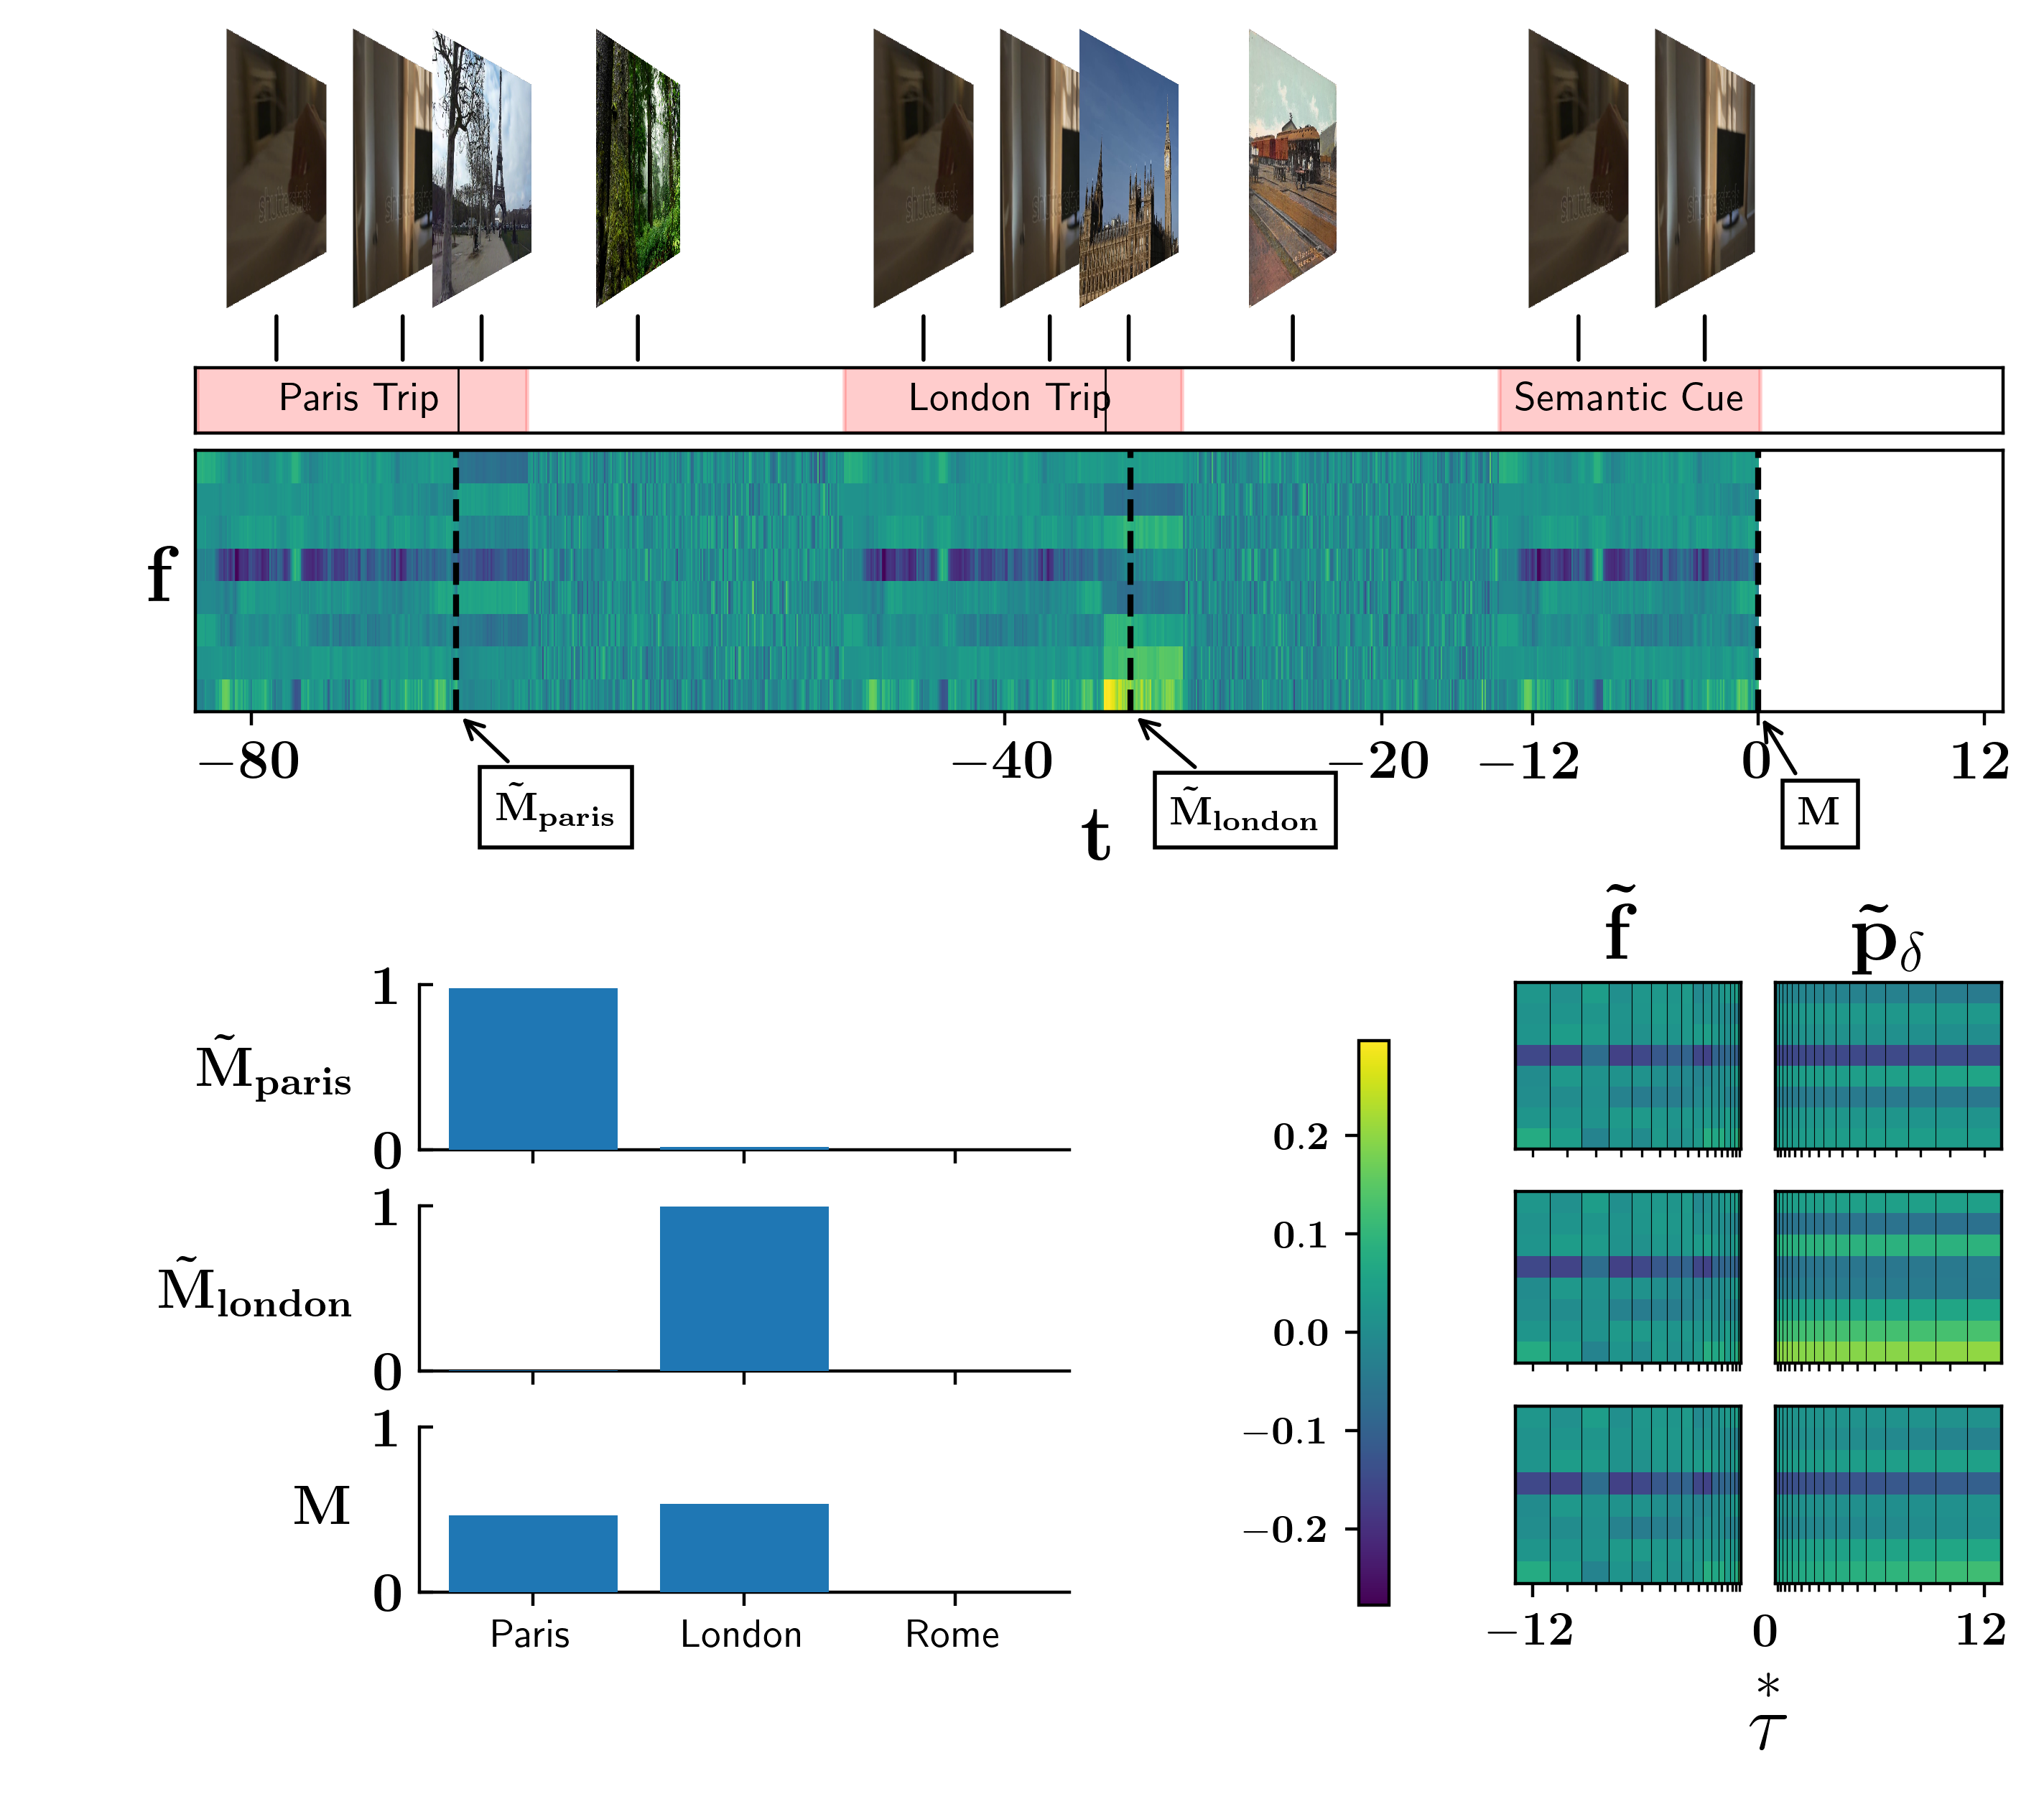

In [30]:

P_delta_sum = {
    "paris": (r"$\tilde{M}_{paris}$",P_delta_sum_paris, rewind_steps_paris),
    "london": (r"$\tilde{M}_{london}$", P_delta_sum_london, rewind_steps_london),
    "M": (r"$M$", P_delta_sum_M, 0),
}

plot_figure(t2, inputs[0], til_f[0], P_delta_sum, x_tstr, labels, selected_frames, timeline_regions, reference_embeddings, dt, save_path=f"figures/M_embeddings_{SAVEFILE_SUFFIX}.png")

torch.Size([20, 16, 3])


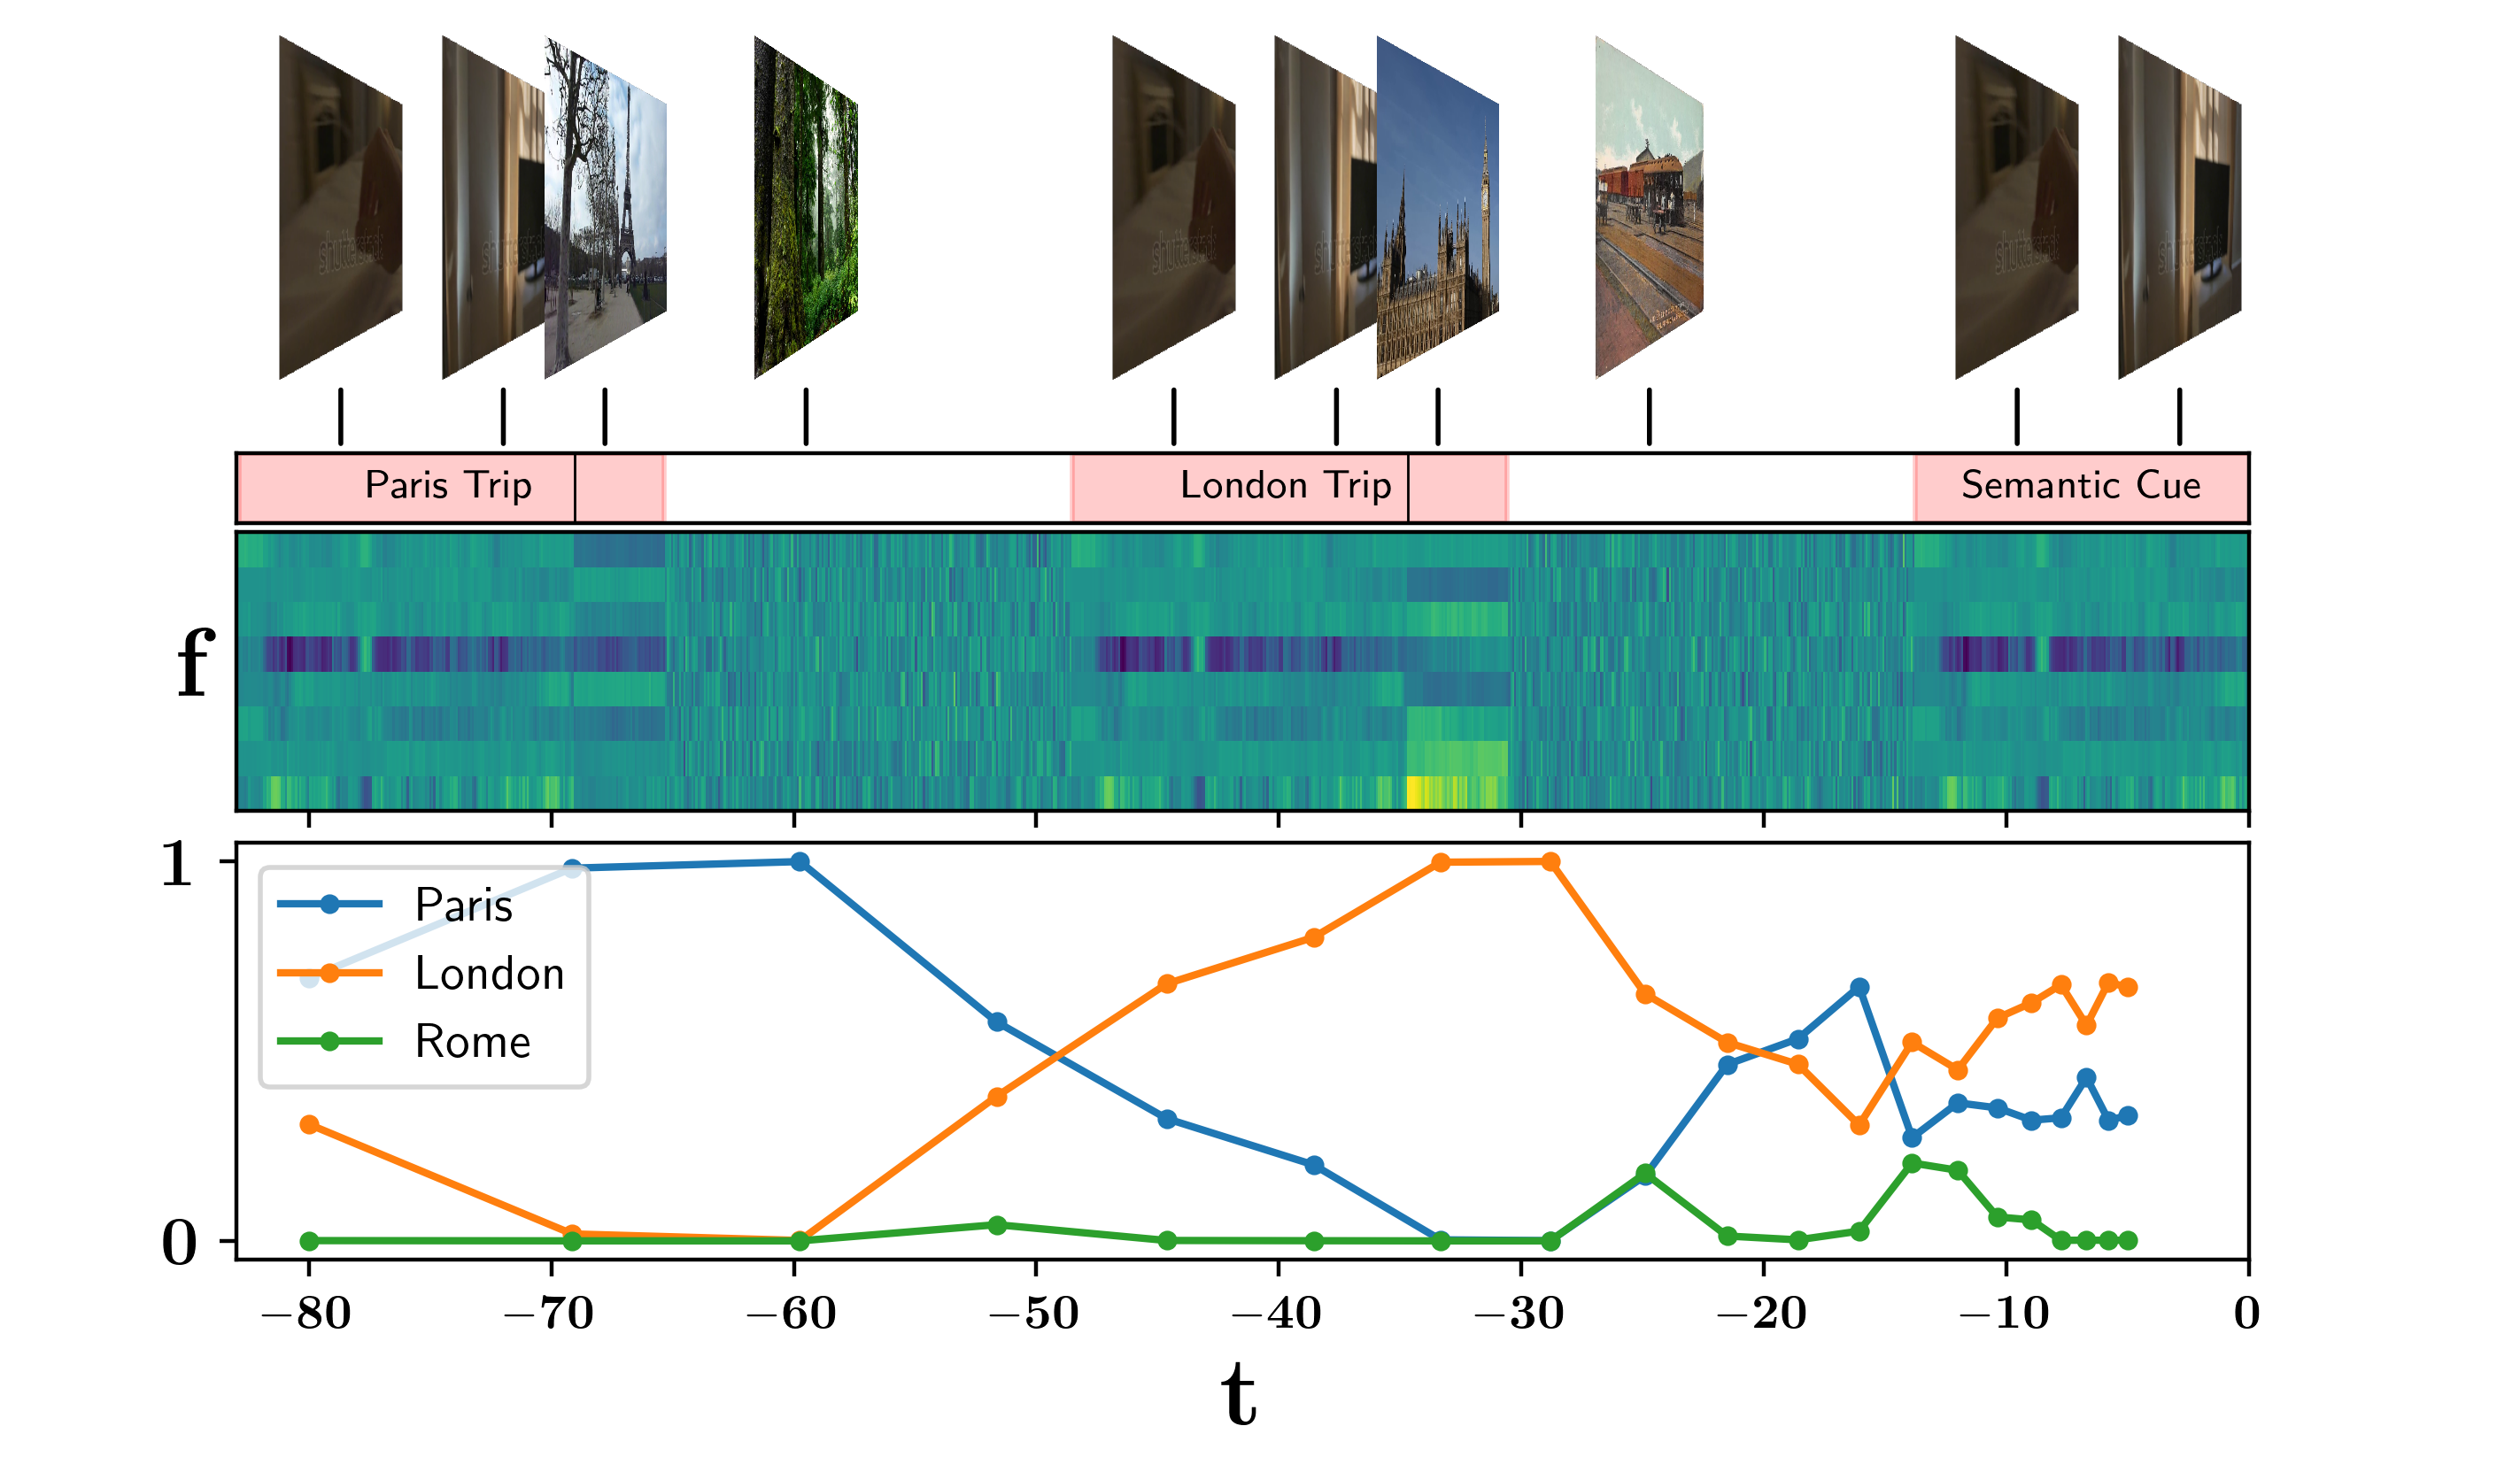

In [28]:
def plot_figure_M(
        t, 
        inputs, 
        til_f, 
        P_delta_sum_dict: dict[str, tuple[str, torch.Tensor, int]], 
        x_tstr, 
        labels, 
        selected_frames: list[tuple[int, Image.Image]], 
        timeline_regions: list[tuple[str, int, int, list[int]]], 
        reference_embeddings: list[tuple[str, torch.Tensor]],
        dt, 
        save_path
    ):
    Nt = inputs.shape[0]
    x = np.linspace(0, Nt, Nt, endpoint=False)
    x_tstr = x_tstr.cpu().numpy()

    n_embed_vis = 8
    
    # get top most different features between first two reference embeddings
    dist = torch.abs(reference_embeddings[0][1][0] - reference_embeddings[1][1][0])
    embed_vis = torch.argsort(dist, descending=True)[:n_embed_vis].cpu().numpy()


    x_min = -83  # secs
    x_max = 0

    vmin = inputs[..., embed_vis].min()
    vmax = inputs[..., embed_vis].max()   

    text = tokenizer(labels).to(device)
    with torch.no_grad(), torch.autocast("cuda"):
        text_embeddings = clip_model.encode_text(text, normalize=True)

    til_f = til_f.T  # (n_features, n_taus) -> (n_taus, n_features)
    
    # normalize feature (embedding) dim
    til_f_normed = til_f / torch.linalg.norm(til_f, dim=-1, keepdim=True)
    
    input_probs = (100.0 * inputs @ text_embeddings.T).softmax(dim=-1).cpu().numpy()
    til_f_probs = (100.0 * til_f_normed @ text_embeddings.double().T).softmax(dim=-1).cpu().numpy()
        
    P_delta_sum_normed_list = []
    P_delta_sum_probs_list = []
    for rewind_idx in range(EM_model.M_model.n_taus):
        til_M_t = EM_model.til_M[rewind_idx]
        P_delta = EM_model.get_P_delta(til_M_t, delta_til_f)
        P_delta_sum = torch.einsum("dtf -> fd", P_delta)
        P_delta_sum = P_delta_sum.T  # (n_features, delta) -> (delta, n_features)
        P_delta_sum_normed = P_delta_sum / torch.linalg.norm(P_delta_sum, dim=-1, keepdim=True)
        P_delta_sum_probs = (100.0 * P_delta_sum_normed @ text_embeddings.double().T).softmax(dim=-1)
        
        P_delta_sum_normed_list.append(P_delta_sum_normed)
        P_delta_sum_probs_list.append(P_delta_sum_probs)

    P_delta_sum_normed = torch.stack(P_delta_sum_normed_list, dim=0)
    P_delta_sum_probs = torch.stack(P_delta_sum_probs_list, dim=0)


    fig = plt.figure(
        figsize=(7, 4),  # w, h
        dpi=200,
        layout="constrained",
        facecolor='w', 
        edgecolor='k', 
    )

    mosaic = [
        ["timeline"], 
        ["inputs"],
        ["probs"]
    ]
    axd = fig.subplot_mosaic(
        mosaic,
        height_ratios=[1, 4, 6],
        sharex=True
    )

    fig.get_layout_engine().set(h_pad=0.01)

    # Timeline
    ax = axd["timeline"]

    # shaded regions
    for label, start, end, marks in timeline_regions:
        ax.axvspan((start-t)*dt, (end-t)*dt, alpha=0.2, color='red')
        ax.text(
            (((start + end) / 2) - t) * dt, 0.5, label, 
            ha="center", va="center", fontsize=8, color='k'
        )
        for mark in marks:
            ax.axvline((mark-t)*dt, color="k", linestyle='-', lw=0.5)

    ax.tick_params(axis='x', which='both', bottom=False)
    ax.set_yticks([])
 
    # selected video frames
    for ix, frame in selected_frames:
        w = frame.width
        h = frame.height

        # perspective warp
        coeffs = find_coefs(
            [(w*0.4, 0), (w*0.4, h), (w*0.6, h*0.8), (w*0.6, h*0.2)],
            [(0, 0), (0, h), (w, h), (w, 0)], 
        )

        frame = frame.convert("RGBA").transform(
            frame.size, Image.PERSPECTIVE, coeffs, Image.BILINEAR
        )

        im = OffsetImage(frame, zoom=70 / frame.height)
        im.image.axes = ax

        ab = AnnotationBbox(im, 
            ((ix - t) * dt, 1),
            xybox=(0., 50.),
            xycoords='data',
            boxcoords="offset points",
            pad=0.0,
            arrowprops=dict(arrowstyle="-", mutation_scale=3),
            frameon=False,
        )
        
        ax.add_artist(ab)


    # Input embeddings
    ax = axd["inputs"]
    ax.pcolormesh(
        (x[:t+1]-t)*dt, 
        np.arange(n_embed_vis), 
        inputs.T.cpu()[embed_vis],
        shading='nearest', cmap='viridis',
        vmin=vmin, vmax=vmax,
    )

    ax.set_xlim(x_min, x_max)

    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_yticks([])
    ax.set_ylabel(r"$f$", fontsize=20, rotation=0, labelpad=5, va="center", ha="right")


    # Predictions
    ax = axd[f"probs"]
    print(P_delta_sum_probs.shape)

    ax.plot(
        -EM_model.M_model.tau_stars.cpu().numpy() * dt,
        P_delta_sum_probs.mean(dim=1).cpu().numpy(),
        ".-",
    )
    ax.set_yticks([0, 1], [r"$0$", r"$1$"], fontsize=14)
    ax.set_xlabel(r"$t$", fontsize=20)

    ax.legend(labels)

    path = Path(save_path)
    path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(path, dpi=300, bbox_inches='tight', pad_inches = 0.0)
    


labels = ["Paris", "London", "Rome"]
plot_figure_M(t2, inputs[0], til_f[0], P_delta_sum, x_tstr, labels, selected_frames, timeline_regions, reference_embeddings, dt, save_path=f"figures/M_probs_{SAVEFILE_SUFFIX}.png")